In [96]:
import os
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as TorchDataset
import torchaudio, torch
import torch.nn as nn
import torch.nn.functional as F # TODO: change all instances of nn and F to use these instead of torch. ...
import pandas as pd


In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

cuda
0
NVIDIA GeForce RTX 4060 Laptop GPU


### Set program hyperparameters

In [98]:
USE_EVEN_DATASETS = True # whether to use all the data, or evenly sized classes

In [99]:
if USE_EVEN_DATASETS:
    EPOCHS = 525
    SAMPLES_PER_CLASS = 25
else:
    EPOCHS = 150
    SAMPLES_PER_CLASS = None

### Preprocess the original dataset

In [100]:
# modify the original dataset to be better structured and have english labels

src = 'dataset'

substitutions = {
    'Aslan' : 'Lion',
    'Esek' : 'Donkey',
    'Inek' : 'Cow',
    'Kedi' : 'Cat',
    'Kopek' : 'Dog',
    'Koyun' : 'Sheep',
    'Kurbaga' : 'Frog',
    'Kus' : 'Bird',
    'Maymun' : 'Monkey',
    'Tavuk' : 'Chicken'
}

og_src_files = os.listdir(src)

for fname in og_src_files:

    # build the path to the folder
    folder_path = os.path.join(src, fname)

    if not os.path.isdir(folder_path): continue # skip if not a folder

    subst_key = None
    for key,val in substitutions.items(): # find the turkish word to switch to english
        if fname.startswith(key):
            subst_key = key
            break
    
    if subst_key is None: continue # could not rename file
    
    new_folder_path = os.path.join(src, substitutions[subst_key])
    
    if not os.path.exists(new_folder_path): os.mkdir(new_folder_path) # make the new folder if it doesn't already exist

    og_files = os.listdir(folder_path)

    for file_name in og_files:
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.isfile(file_path): continue # this is not a file

        new_file_name = file_name
        if file_name.startswith(subst_key.lower()) or file_name.startswith(subst_key):
            new_file_name = substitutions[subst_key] + file_name[len(subst_key):]
        elif file_name.startswith(substitutions[subst_key].lower()) or file_name.startswith(substitutions[subst_key]):
            new_file_name = substitutions[subst_key] + file_name[len(substitutions[subst_key]):]
        
        new_file_path = os.path.join(new_folder_path, new_file_name)
        print(new_file_path)
        os.rename(file_path, new_file_path)

    os.rmdir(folder_path)
    


### Test the dataset

(190400,) 16000


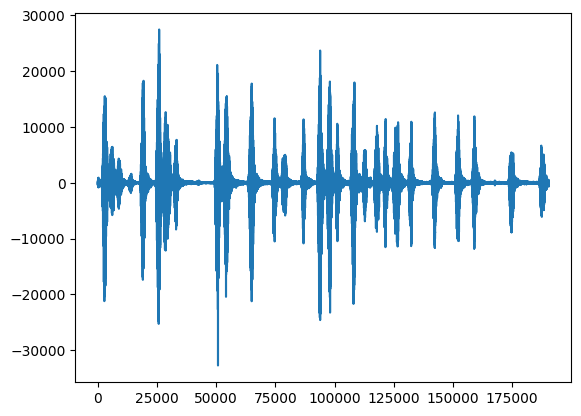

In [101]:
samplerate, data = wavfile.read('dataset/Dog/Dog_2.wav')
print(data.shape, samplerate)
plt.plot(data)
Audio(data, rate=samplerate)

### Data Access Helper Functions

In [102]:
labels = sorted(list(substitutions.values()))
print(labels)

def load_all_file_names_and_labels(root, samples_per_class=None):
    data_points = []
    for folder in os.listdir(root):
        folder_path = os.path.join(root, folder)
        if not os.path.isdir(folder_path): continue

        label = folder
        
        samples_for_this_class = 0
        for datapoint in os.listdir(folder_path):
            data_path = os.path.join(folder_path, datapoint)
            if not os.path.isfile(data_path): continue
            samples_for_this_class += 1
            data_points.append((data_path, label))
            if samples_per_class is not None and samples_per_class == samples_for_this_class: break
    return np.array(data_points)

def one_hot_lookup(labels):
    lookup = {}
    for i, label in enumerate(labels):
        lookup[label] = i
    return lookup

['Bird', 'Cat', 'Chicken', 'Cow', 'Dog', 'Donkey', 'Frog', 'Lion', 'Monkey', 'Sheep']


### Audio Processing Helper Functions

In [103]:
def audio_subclip(audio, time, samplerate):
    audio_len = audio.shape[-1]

    max_start = audio_len - (time * samplerate) + 1
    start_idx = torch.randint(0, max_start, size=(1,))
    clip = audio[:, start_idx: start_idx + (time * samplerate)]

    return clip

def pad_audio(audio, time, samplerate):
    audio_len = audio.shape[-1]

    if audio_len >= time * samplerate: return audio

    zeros_needed = time*samplerate - audio_len
    padded = torch.nn.functional.pad(audio, (0, zeros_needed), value=0)

    return padded

def single_channel(audio):
    return audio[[0],:]

### Dataset Class

In [104]:
class AnimalAudioDataset(TorchDataset):
    def __init__(self, dataset_path, labels, type = 'wave'):
        assert type in ['wave', 'full', 'freq']

        self.data_points = load_all_file_names_and_labels(dataset_path, SAMPLES_PER_CLASS)
        self.labels = labels
        self.lookup = one_hot_lookup(labels)
        self.universal_sample_rate = 4000 # 8000 is the min of our original data
        self.clip_time = 1 # 1 second clips
        self.spikes_path = 'spikes'
        self.type = type
        self.full_data = [self.get_item_helper(x).to(device) for x in range(len(self.data_points))]
        self.full_labels = torch.tensor([self.lookup[x[1]] for x in self.data_points]).to(device)
        self.torch_sr = torch.tensor(self.universal_sample_rate).to(device)

    def get_item_helper(self, index: int):
        path, _ = self.data_points[index]
        waveform, sample_rate = torchaudio.load(path)
        one_channel = single_channel(waveform) # some wav files are dual channel audio
        resampled_waveform = torchaudio.functional.resample(one_channel, orig_freq=sample_rate, new_freq=self.universal_sample_rate)
        
        full_data = resampled_waveform

        if self.type != 'wave':
            feature_count = 10
            start = 0
            if self.type == 'full':
                feature_count = 11
                start = 1
                
            full_data = torch.zeros((feature_count, full_data.shape[-1]))
            if self.type == 'full':
                full_data[0] = resampled_waveform

            spikes = torch.tensor(np.load(os.path.join(self.spikes_path, path) + '.npy'))
            data_len = min(spikes.shape[-1], full_data.shape[-1])
            full_data[start:, :data_len] = spikes[:, :data_len]

        return full_data


    def __getitem__(self, index: int): # -> Tuple[Tensor, int, str]:
        data = self.full_data[index]
        padded = pad_audio(data, self.clip_time, self.universal_sample_rate)
        clipped = audio_subclip(padded, self.clip_time, self.universal_sample_rate)

        return clipped, self.universal_sample_rate, self.full_labels[index]

    def __len__(self):
        return len(self.data_points)

In [105]:
wave_dataset = AnimalAudioDataset('dataset', labels, type='wave')
full_dataset = AnimalAudioDataset('dataset', labels, type='full')
freq_dataset = AnimalAudioDataset('dataset', labels, type='freq')

### Dataloader Generation

In [106]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def get_train_test_loaders(dataset, test_size = 0.2):
    # we use this method to ensure the test/train have the same proportions of each class

    targets = [dataset.lookup[x] for x in dataset.data_points[:,1]]
    train_indices, test_indices, _, _ = train_test_split(
        range(len(dataset)),
        targets,
        stratify=targets,
        test_size=test_size
    )

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False)
    
    return train_loader, test_loader

In [107]:
assert 'soundfile' in torchaudio.list_audio_backends()

### M5 Model

Code based on https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

Small reduction in scale to the M5 model

In [108]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        # self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        # self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        # x = self.conv4(x)
        # x = F.relu(self.bn4(x))
        # x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

### Evaluation Functions

For both these and the training, we assume the data and model will already be on the same device

In [109]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def correct_per_class(pred, target):
    correct = np.zeros((10))
    total = np.zeros((10))
    for i in range(target.shape[0]):
        total[target[i]] += 1
        if pred[i][0] == target[i]:
            correct[target[i]] += 1
    return correct, total


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def eval(model, data_loader, rnn=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, sample_rate, labels = data 
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]
            # print(torch.argmax(outputs), torch.argmax(labels))
            pred = get_likely_index(outputs)
            correct += number_of_correct(pred, labels)
    return correct/len(data_loader.dataset)

def eval_per_class(model, data_loader, rnn=False):
    model.eval()
    correct = np.zeros((10))
    total = np.zeros((10))
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, sample_rate, labels = data
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]
            # print(torch.argmax(outputs), torch.argmax(labels))
            pred = get_likely_index(outputs)
            new_correct, new_total = correct_per_class(pred, labels)
            correct += new_correct
            total += new_total
    return correct/total

### Training Functions

In [110]:
def train(model, loss_fn, optimizer, training_loader, epochs, rnn=False, get_accs=False, test_loader=None):
    if get_accs: assert (test_loader is not None)
    losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        model.train()
        print(f"Start of epoch {epoch}")
        running_loss = 0.

        for i, data in enumerate(training_loader):
            inputs, sample_rate, labels = data
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]

            loss = loss_fn(outputs.squeeze(), labels)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        losses.append(running_loss/len(training_loader))
        print(losses[-1])

        if get_accs:
            train_accs.append(eval(model, training_loader, rnn=rnn))
            test_accs.append(eval(model, test_loader, rnn=rnn))
    
    if get_accs: return losses, train_accs, test_accs
    return losses

### Plotting Functions

In [111]:
def plot_loss_over_time(losses, title_addition=''):
    plt.figure()
    plt.plot(losses, color='blue')
    plt.title("Training Loss Over Time" + title_addition)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss (NLL)")
    plt.show()

def plot_train_test_accs(train_accs, test_accs, title_addition=''):
    plt.figure()
    plt.plot(train_accs, label="Training", color='blue')
    plt.plot(test_accs, label="Testing", color='red')
    plt.title("Training and Testing Accuracy Over Time" + title_addition)
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

def plot_class_accuracies(accs, classes, title_addition=''):
    accs = 100*np.array(accs).round(2)
    plt.figure()
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Per Class" + title_addition)
    acc_bar = plt.bar(classes, accs, color='green', label='Correct %')
    plt.bar_label(acc_bar, label_type='center')
    inc_bar = plt.bar(classes, 100 - accs, bottom = accs, color='red', label='Incorrect %')
    plt.bar_label(inc_bar, label_type='center')

    plt.legend()
    plt.show()

def plot_features(data_loader, type, title_addition=''):
    assert type in ['wave', 'full', 'freq']
    
    x = None
    for inputs, _, _ in data_loader:
        x = inputs[0]
        break

    start = 0
    if type != 'freq':
        start += 1
        plt.figure()
        plt.title("Waveform" + title_addition)
        plt.plot(x[0])
        plt.show()
    
    if type != 'wave':
        for i in range(x.shape[-2] - start):
            plt.figure()
            plt.title("Firing rates, cf=" + str(1000*(i+1)) + title_addition)
            plt.plot(x[start + i])
            plt.show()

def plot_waveform(file, i, title_add=''):
    spikes = torch.tensor(np.load(os.path.join('spikes', file) + '.npy'))
    plt.figure()
    plt.title(title_add + "Firing rates, cf=" + str(1000*(i+1)))
    plt.ylabel("Firing Rate")
    plt.xlabel("Time Sample # at 4 KHz (x=4000 is at 1 second)")
    plt.plot(spikes[i])
    plt.show()

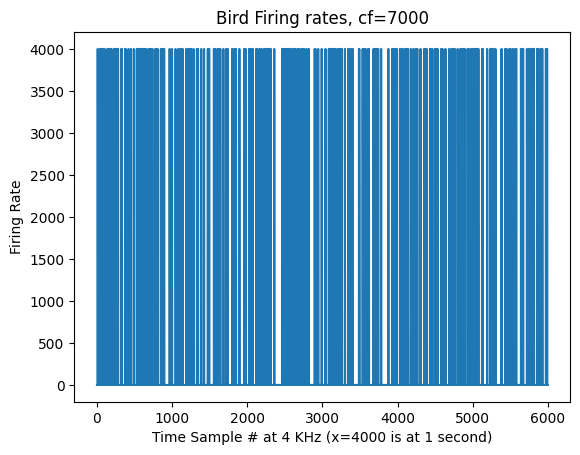

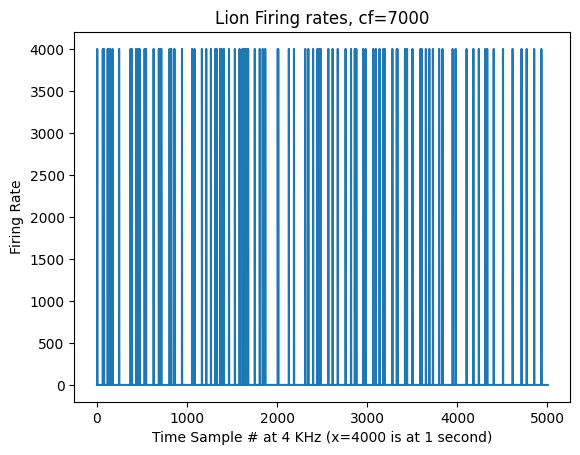

In [112]:
plot_waveform(os.path.join('dataset', 'Bird', 'Bird_1.wav'), 6, 'Bird ')
plot_waveform(os.path.join('dataset', 'Lion', 'Lion_2.wav'), 6, 'Lion ')

### Driver Code

Start of epoch 0
2.438725709915161
Start of epoch 1
2.3409078121185303
Start of epoch 2
2.2321643829345703
Start of epoch 3
2.1985692977905273
Start of epoch 4
2.1709630489349365
Start of epoch 5
2.102656364440918
Start of epoch 6
2.0835790634155273
Start of epoch 7
2.0506954193115234
Start of epoch 8
2.0220518112182617
Start of epoch 9
1.9757755994796753
Start of epoch 10
1.9605287313461304
Start of epoch 11
1.9397627115249634
Start of epoch 12
1.9312150478363037
Start of epoch 13
1.9022037982940674
Start of epoch 14
1.8621587753295898
Start of epoch 15
1.8533117771148682
Start of epoch 16
1.8309516906738281
Start of epoch 17
1.7895028591156006
Start of epoch 18
1.7906876802444458
Start of epoch 19
1.7766188383102417
Start of epoch 20
1.7388688325881958
Start of epoch 21
1.7031426429748535
Start of epoch 22
1.6727502346038818
Start of epoch 23
1.6671266555786133
Start of epoch 24
1.6575698852539062
Start of epoch 25
1.6541037559509277
Start of epoch 26
1.6268343925476074
Start of epoc

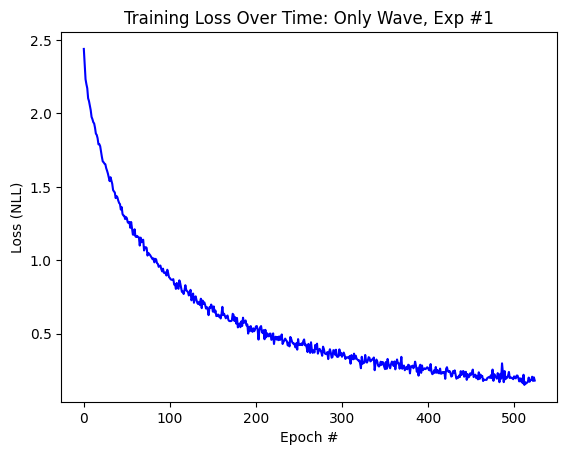

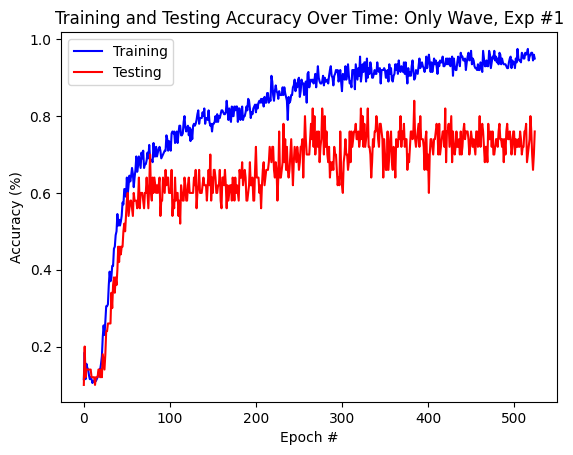

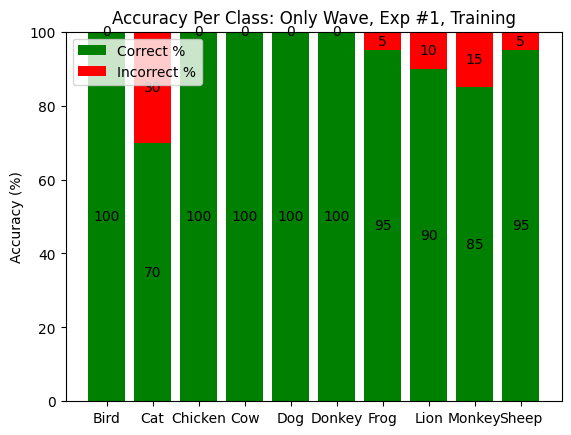

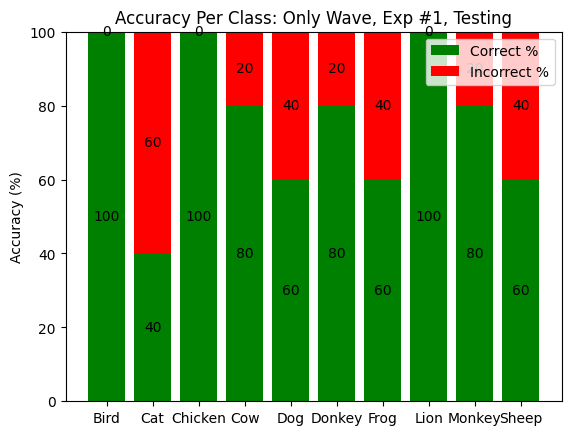

Start of epoch 0
2.560148000717163
Start of epoch 1
2.455355167388916
Start of epoch 2
2.3680238723754883
Start of epoch 3
2.258312225341797
Start of epoch 4
2.2024431228637695
Start of epoch 5
2.130342483520508
Start of epoch 6
2.0879459381103516
Start of epoch 7
2.019669532775879
Start of epoch 8
2.0129802227020264
Start of epoch 9
1.9797519445419312
Start of epoch 10
1.9547609090805054
Start of epoch 11
1.9549716711044312
Start of epoch 12
1.9033784866333008
Start of epoch 13
1.8665881156921387
Start of epoch 14
1.8472886085510254
Start of epoch 15
1.8379687070846558
Start of epoch 16
1.8136993646621704
Start of epoch 17
1.771150827407837
Start of epoch 18
1.8163414001464844
Start of epoch 19
1.7742384672164917
Start of epoch 20
1.755995273590088
Start of epoch 21
1.740410566329956
Start of epoch 22
1.7246654033660889
Start of epoch 23
1.704750657081604
Start of epoch 24
1.698823094367981
Start of epoch 25
1.6857904195785522
Start of epoch 26
1.696557879447937
Start of epoch 27
1.67

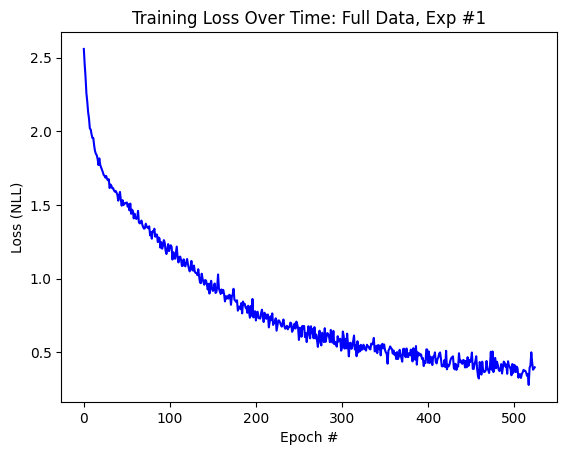

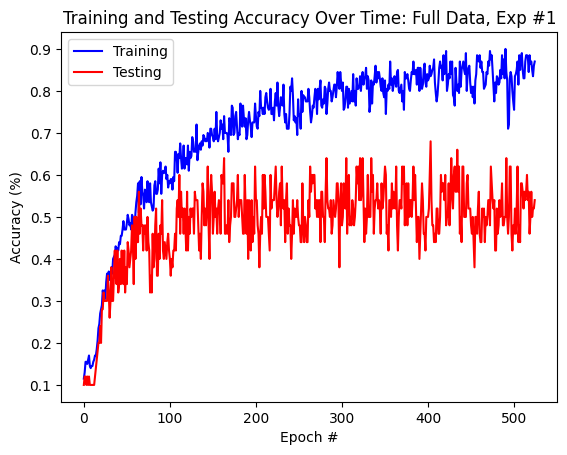

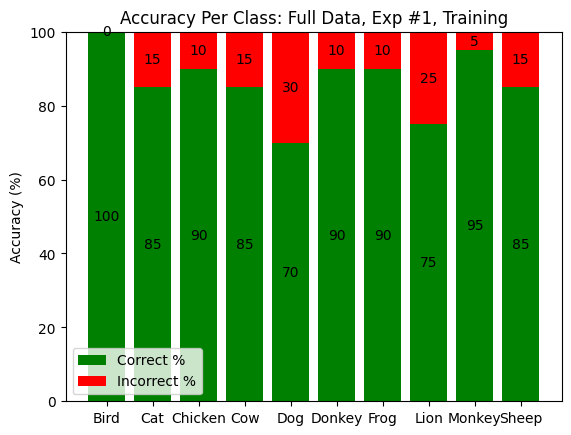

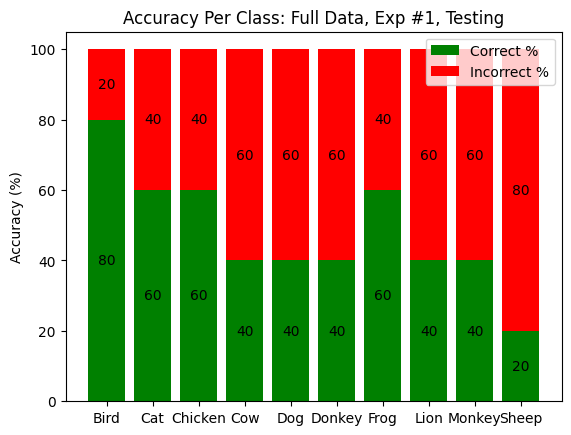

Start of epoch 0
2.494357109069824
Start of epoch 1
2.402919054031372
Start of epoch 2
2.3006057739257812
Start of epoch 3
2.2259697914123535
Start of epoch 4
2.1734981536865234
Start of epoch 5
2.1187732219696045
Start of epoch 6
2.043416976928711
Start of epoch 7
1.9967955350875854
Start of epoch 8
1.9598056077957153
Start of epoch 9
1.9505953788757324
Start of epoch 10
1.9039154052734375
Start of epoch 11
1.8764642477035522
Start of epoch 12
1.8087431192398071
Start of epoch 13
1.8182876110076904
Start of epoch 14
1.7875256538391113
Start of epoch 15
1.777296543121338
Start of epoch 16
1.7409940958023071
Start of epoch 17
1.7325890064239502
Start of epoch 18
1.6949636936187744
Start of epoch 19
1.6749060153961182
Start of epoch 20
1.6493346691131592
Start of epoch 21
1.673295259475708
Start of epoch 22
1.6398602724075317
Start of epoch 23
1.6294562816619873
Start of epoch 24
1.6188769340515137
Start of epoch 25
1.6010493040084839
Start of epoch 26
1.5728451013565063
Start of epoch 2

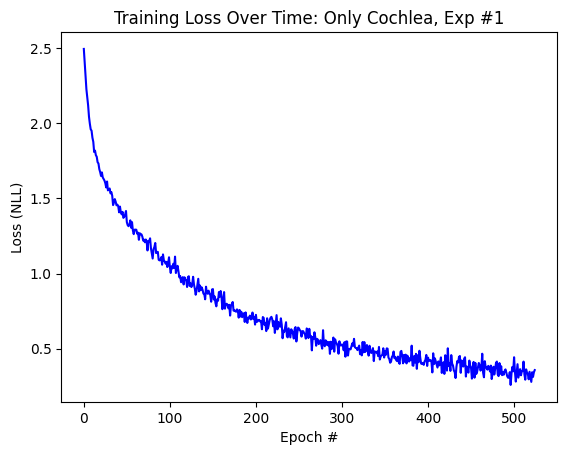

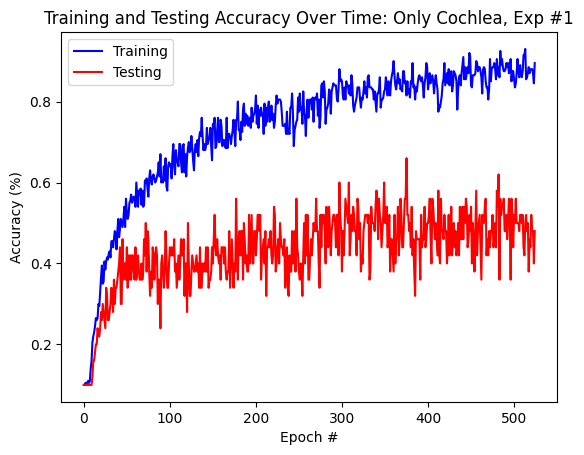

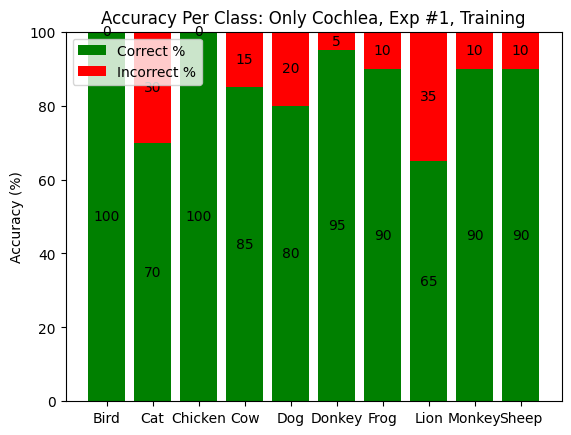

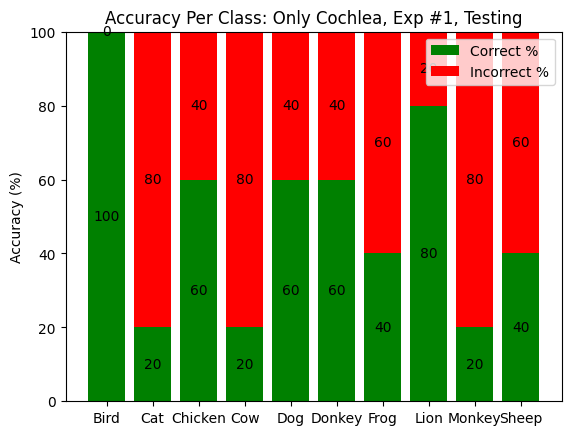

Start of epoch 0
2.394247531890869
Start of epoch 1
2.3140106201171875
Start of epoch 2
2.244539260864258
Start of epoch 3
2.2017908096313477
Start of epoch 4
2.1507608890533447
Start of epoch 5
2.118062973022461
Start of epoch 6
2.0760653018951416
Start of epoch 7
2.029721260070801
Start of epoch 8
2.005737781524658
Start of epoch 9
1.9595327377319336
Start of epoch 10
1.9507191181182861
Start of epoch 11
1.9260673522949219
Start of epoch 12
1.8912289142608643
Start of epoch 13
1.8702263832092285
Start of epoch 14
1.8574738502502441
Start of epoch 15
1.8213653564453125
Start of epoch 16
1.8037692308425903
Start of epoch 17
1.787665605545044
Start of epoch 18
1.7368160486221313
Start of epoch 19
1.753489375114441
Start of epoch 20
1.7184219360351562
Start of epoch 21
1.7005213499069214
Start of epoch 22
1.6625372171401978
Start of epoch 23
1.623428463935852
Start of epoch 24
1.6119688749313354
Start of epoch 25
1.6171212196350098
Start of epoch 26
1.5891969203948975
Start of epoch 27
1

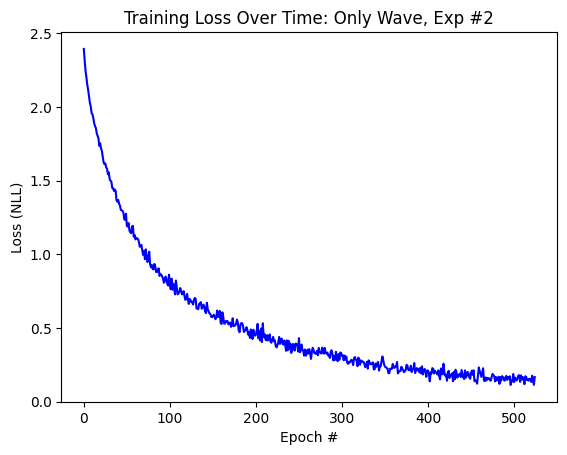

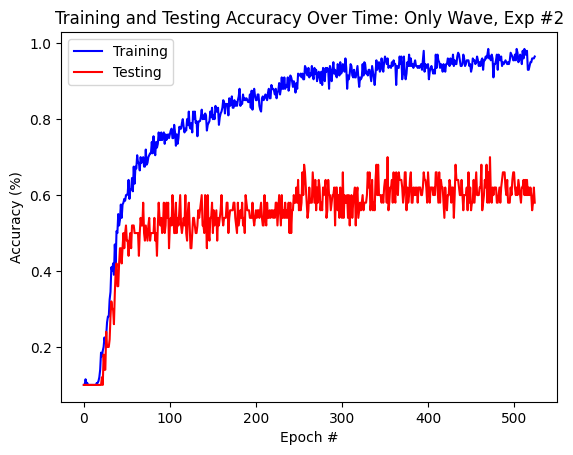

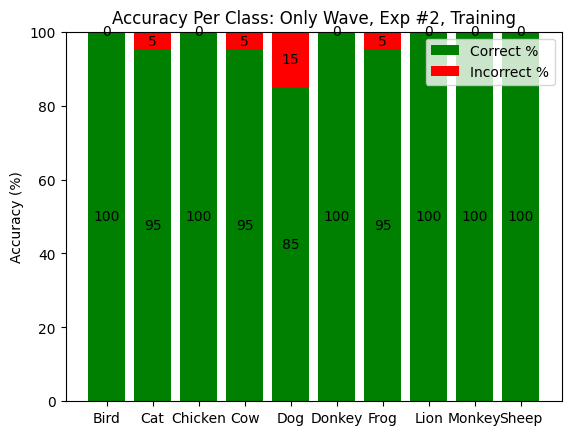

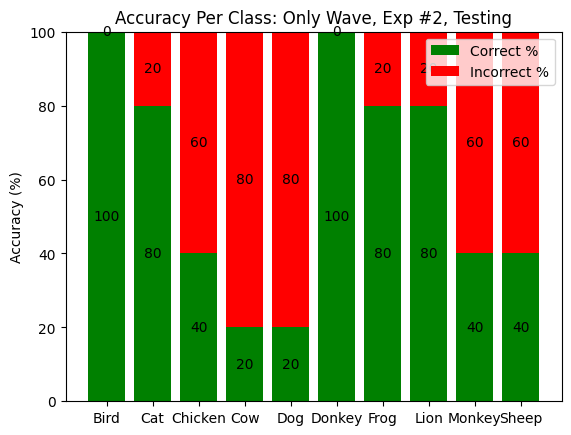

Start of epoch 0
2.4375760555267334
Start of epoch 1
2.3377339839935303
Start of epoch 2
2.26739501953125
Start of epoch 3
2.18857479095459
Start of epoch 4
2.1292226314544678
Start of epoch 5
2.0655033588409424
Start of epoch 6
2.0153822898864746
Start of epoch 7
2.0071096420288086
Start of epoch 8
1.975718379020691
Start of epoch 9
1.9278548955917358
Start of epoch 10
1.892835259437561
Start of epoch 11
1.8833318948745728
Start of epoch 12
1.8558306694030762
Start of epoch 13
1.8224438428878784
Start of epoch 14
1.7883704900741577
Start of epoch 15
1.784332275390625
Start of epoch 16
1.7838391065597534
Start of epoch 17
1.7550767660140991
Start of epoch 18
1.7424932718276978
Start of epoch 19
1.7181220054626465
Start of epoch 20
1.7065578699111938
Start of epoch 21
1.6879011392593384
Start of epoch 22
1.7155578136444092
Start of epoch 23
1.6744956970214844
Start of epoch 24
1.6261810064315796
Start of epoch 25
1.6750154495239258
Start of epoch 26
1.6629582643508911
Start of epoch 27


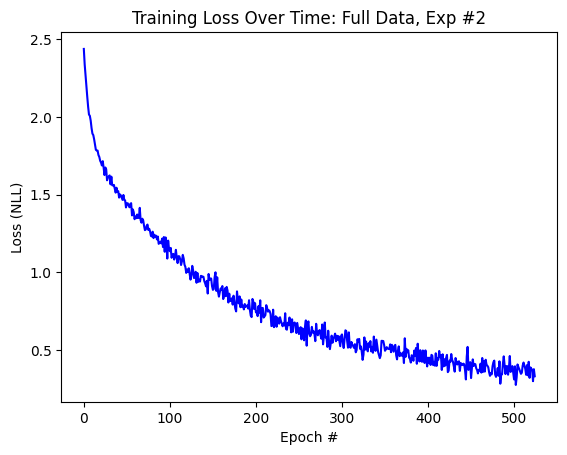

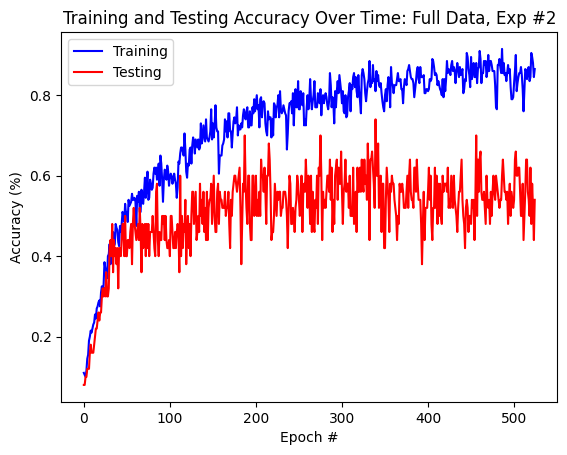

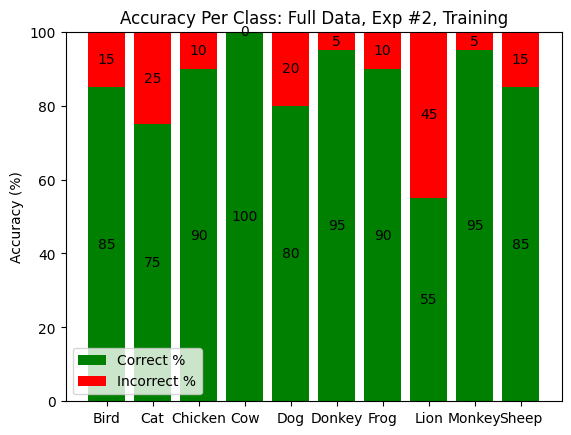

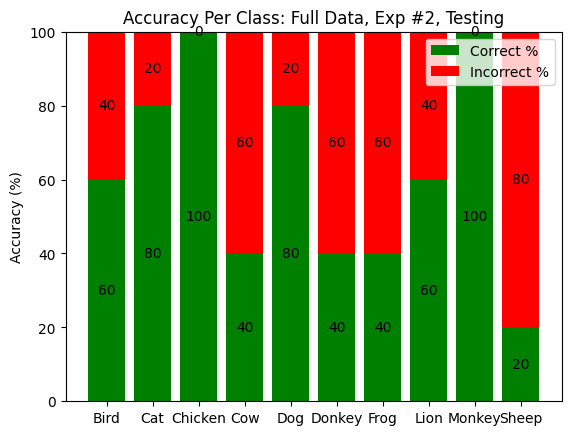

Start of epoch 0
2.432936191558838
Start of epoch 1
2.3249425888061523
Start of epoch 2
2.235214948654175
Start of epoch 3
2.201192855834961
Start of epoch 4
2.1351070404052734
Start of epoch 5
2.0968308448791504
Start of epoch 6
2.039780616760254
Start of epoch 7
2.020427942276001
Start of epoch 8
2.0046756267547607
Start of epoch 9
1.9648891687393188
Start of epoch 10
1.9273934364318848
Start of epoch 11
1.905819058418274
Start of epoch 12
1.8743040561676025
Start of epoch 13
1.849733591079712
Start of epoch 14
1.8306201696395874
Start of epoch 15
1.835983395576477
Start of epoch 16
1.8138138055801392
Start of epoch 17
1.7803400754928589
Start of epoch 18
1.7643918991088867
Start of epoch 19
1.7517307996749878
Start of epoch 20
1.7049180269241333
Start of epoch 21
1.7054193019866943
Start of epoch 22
1.7189929485321045
Start of epoch 23
1.6744437217712402
Start of epoch 24
1.6380184888839722
Start of epoch 25
1.6701518297195435
Start of epoch 26
1.6562267541885376
Start of epoch 27
1

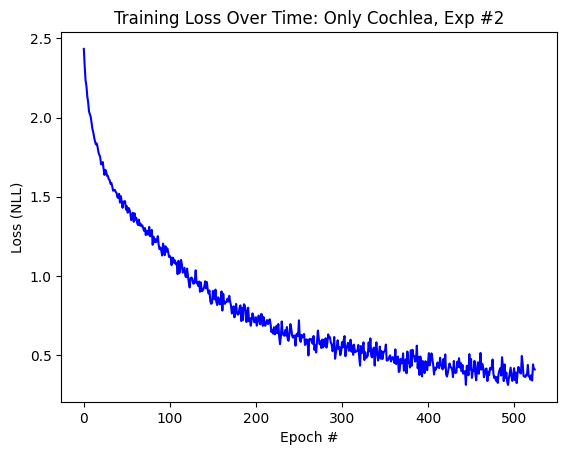

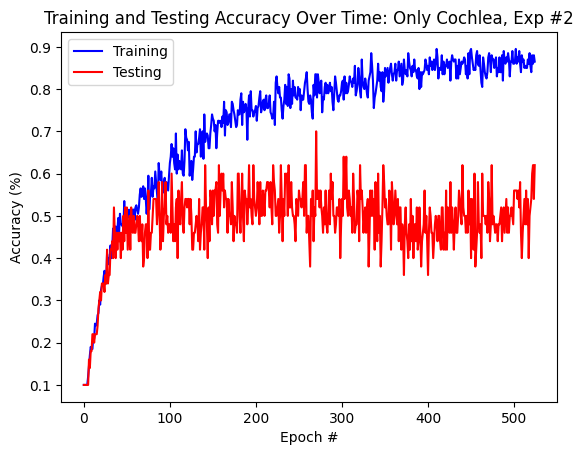

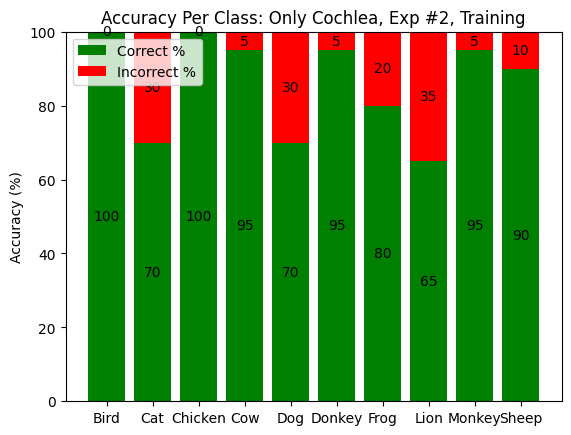

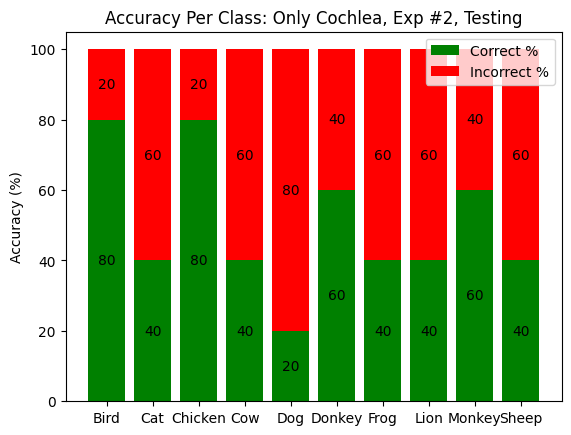

Start of epoch 0
2.4467666149139404
Start of epoch 1
2.352233648300171
Start of epoch 2
2.281935691833496
Start of epoch 3
2.2644824981689453
Start of epoch 4
2.20465087890625
Start of epoch 5
2.188190221786499
Start of epoch 6
2.116086483001709
Start of epoch 7
2.129925012588501
Start of epoch 8
2.0883591175079346
Start of epoch 9
2.0070455074310303
Start of epoch 10
2.0304007530212402
Start of epoch 11
1.976284384727478
Start of epoch 12
1.937794804573059
Start of epoch 13
1.9171909093856812
Start of epoch 14
1.9117803573608398
Start of epoch 15
1.8972060680389404
Start of epoch 16
1.870451807975769
Start of epoch 17
1.8423632383346558
Start of epoch 18
1.8233437538146973
Start of epoch 19
1.7608145475387573
Start of epoch 20
1.7829524278640747
Start of epoch 21
1.7652428150177002
Start of epoch 22
1.7436189651489258
Start of epoch 23
1.726660132408142
Start of epoch 24
1.693914532661438
Start of epoch 25
1.6759904623031616
Start of epoch 26
1.6679682731628418
Start of epoch 27
1.644

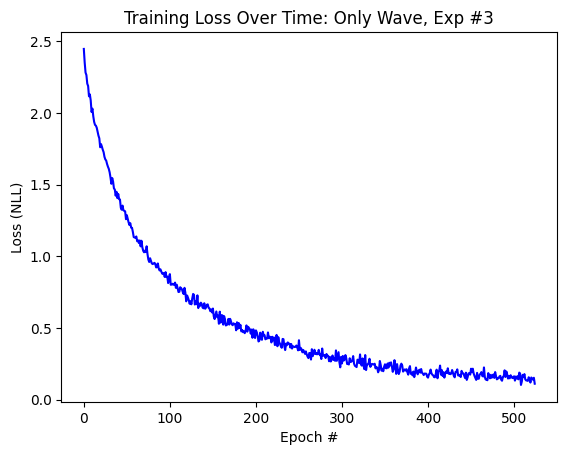

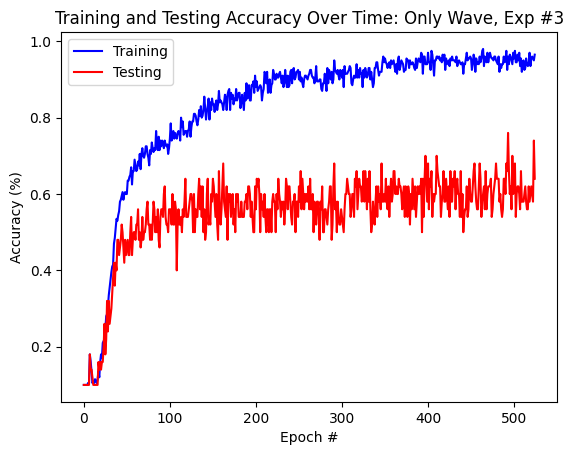

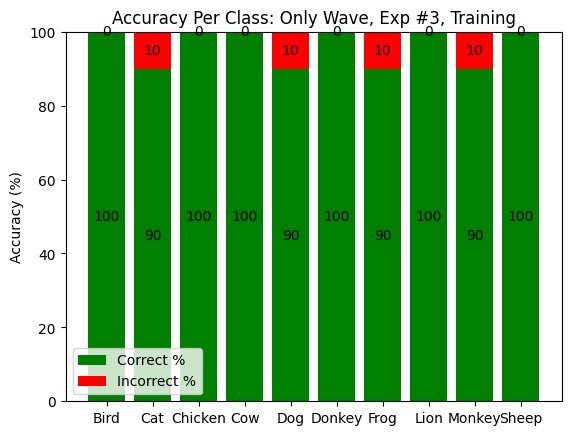

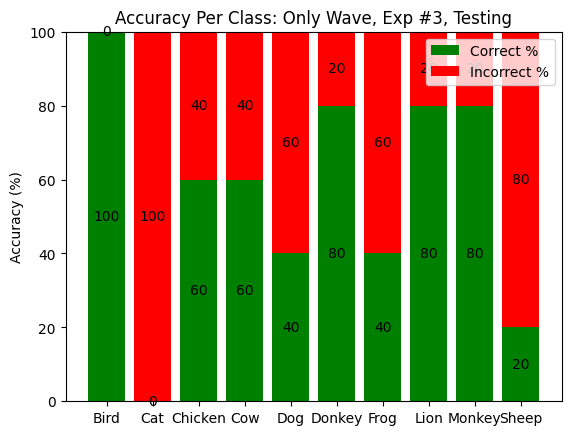

Start of epoch 0
2.4039151668548584
Start of epoch 1
2.3520731925964355
Start of epoch 2
2.2497217655181885
Start of epoch 3
2.189220905303955
Start of epoch 4
2.118166923522949
Start of epoch 5
2.0719008445739746
Start of epoch 6
2.0374441146850586
Start of epoch 7
1.995294213294983
Start of epoch 8
1.9866621494293213
Start of epoch 9
1.9559494256973267
Start of epoch 10
1.9217898845672607
Start of epoch 11
1.903372049331665
Start of epoch 12
1.8858453035354614
Start of epoch 13
1.8808181285858154
Start of epoch 14
1.8541063070297241
Start of epoch 15
1.8243026733398438
Start of epoch 16
1.8295637369155884
Start of epoch 17
1.796867847442627
Start of epoch 18
1.802639365196228
Start of epoch 19
1.7526147365570068
Start of epoch 20
1.7442876100540161
Start of epoch 21
1.720362901687622
Start of epoch 22
1.7033458948135376
Start of epoch 23
1.7007265090942383
Start of epoch 24
1.6980973482131958
Start of epoch 25
1.6701078414916992
Start of epoch 26
1.6150017976760864
Start of epoch 27


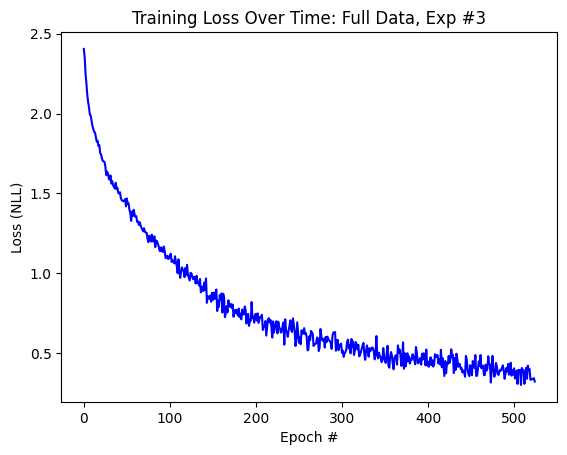

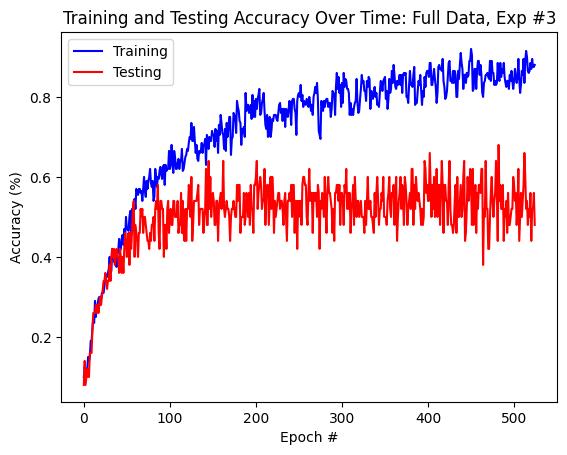

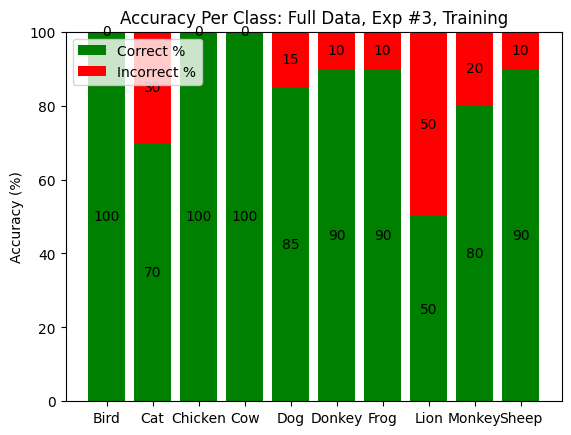

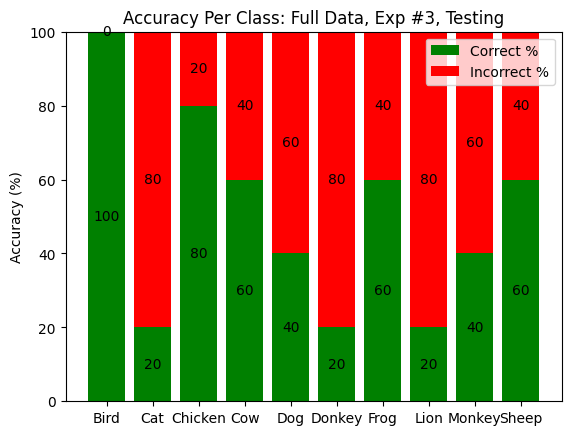

Start of epoch 0
2.520237684249878
Start of epoch 1
2.4205832481384277
Start of epoch 2
2.3213095664978027
Start of epoch 3
2.2462637424468994
Start of epoch 4
2.1340603828430176
Start of epoch 5
2.1103250980377197
Start of epoch 6
2.0913193225860596
Start of epoch 7
2.0078213214874268
Start of epoch 8
2.0044350624084473
Start of epoch 9
1.9439189434051514
Start of epoch 10
1.9274803400039673
Start of epoch 11
1.9054805040359497
Start of epoch 12
1.8607579469680786
Start of epoch 13
1.8480530977249146
Start of epoch 14
1.8235790729522705
Start of epoch 15
1.796168565750122
Start of epoch 16
1.7749377489089966
Start of epoch 17
1.7303237915039062
Start of epoch 18
1.738183856010437
Start of epoch 19
1.7393035888671875
Start of epoch 20
1.7200289964675903
Start of epoch 21
1.6884207725524902
Start of epoch 22
1.7090559005737305
Start of epoch 23
1.6624220609664917
Start of epoch 24
1.6595731973648071
Start of epoch 25
1.6662390232086182
Start of epoch 26
1.6674081087112427
Start of epoch

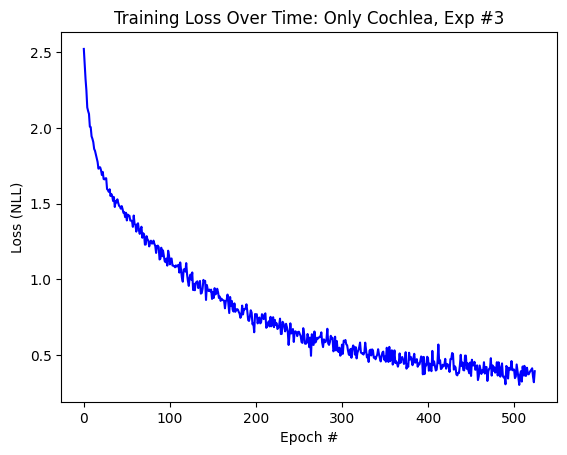

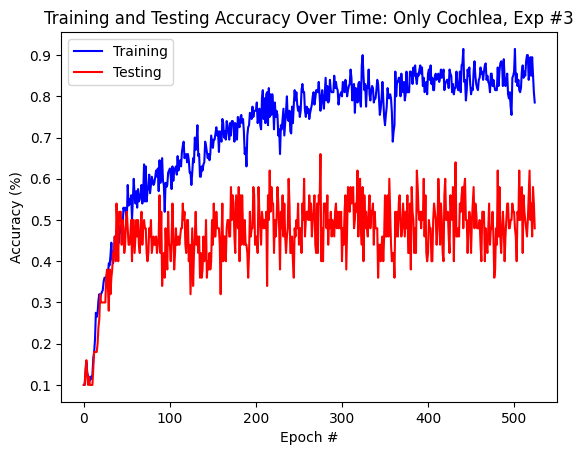

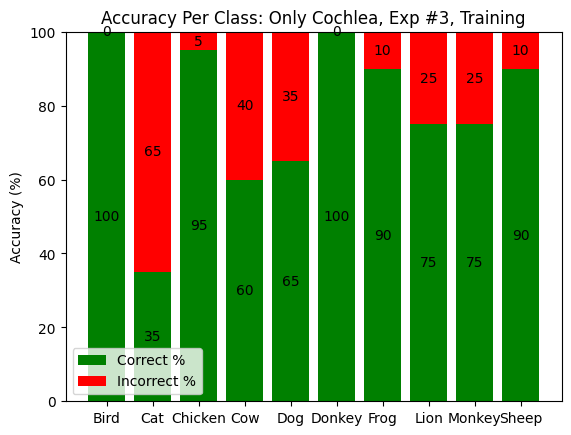

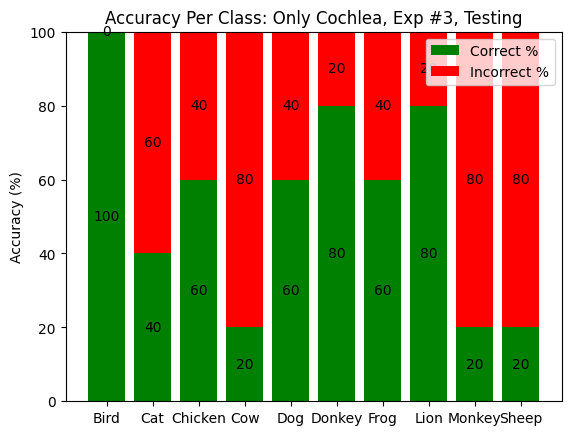

Start of epoch 0
2.3625411987304688
Start of epoch 1
2.312112808227539
Start of epoch 2
2.2130610942840576
Start of epoch 3
2.1703274250030518
Start of epoch 4
2.125934362411499
Start of epoch 5
2.101902961730957
Start of epoch 6
2.0561347007751465
Start of epoch 7
2.0386416912078857
Start of epoch 8
2.0193393230438232
Start of epoch 9
1.9962974786758423
Start of epoch 10
1.9318451881408691
Start of epoch 11
1.9045825004577637
Start of epoch 12
1.8725461959838867
Start of epoch 13
1.8455058336257935
Start of epoch 14
1.8186801671981812
Start of epoch 15
1.815051555633545
Start of epoch 16
1.7926198244094849
Start of epoch 17
1.791035771369934
Start of epoch 18
1.7402005195617676
Start of epoch 19
1.7262576818466187
Start of epoch 20
1.7186051607131958
Start of epoch 21
1.678983449935913
Start of epoch 22
1.6466137170791626
Start of epoch 23
1.6398845911026
Start of epoch 24
1.6238425970077515
Start of epoch 25
1.593877911567688
Start of epoch 26
1.5908230543136597
Start of epoch 27
1.5

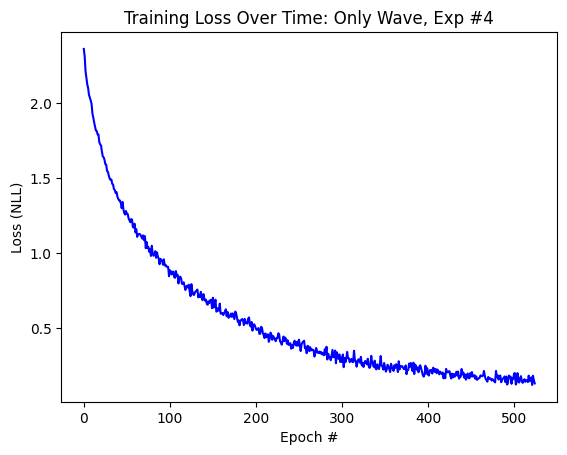

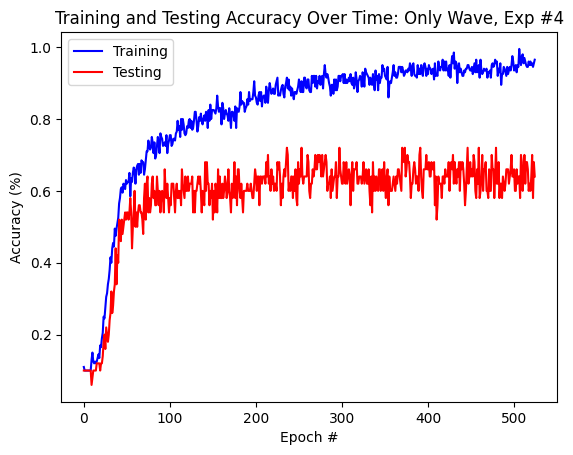

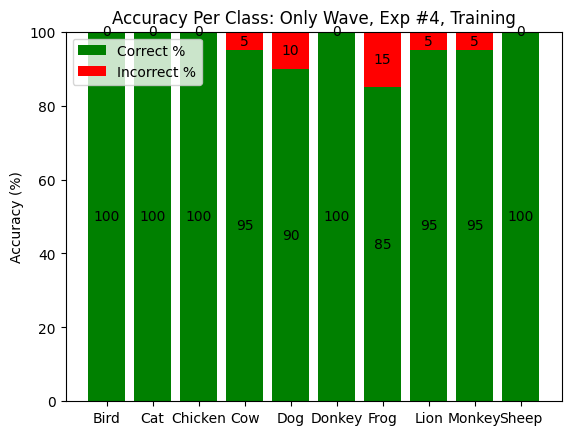

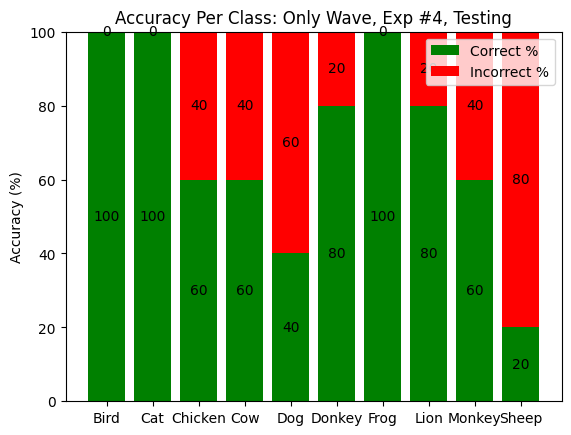

Start of epoch 0
2.552398681640625
Start of epoch 1
2.4207096099853516
Start of epoch 2
2.3374760150909424
Start of epoch 3
2.2644200325012207
Start of epoch 4
2.1958258152008057
Start of epoch 5
2.138918399810791
Start of epoch 6
2.106609582901001
Start of epoch 7
2.062548875808716
Start of epoch 8
2.0238568782806396
Start of epoch 9
1.971410870552063
Start of epoch 10
1.9453942775726318
Start of epoch 11
1.9440789222717285
Start of epoch 12
1.9204694032669067
Start of epoch 13
1.8660130500793457
Start of epoch 14
1.8430825471878052
Start of epoch 15
1.8368421792984009
Start of epoch 16
1.8047780990600586
Start of epoch 17
1.8002222776412964
Start of epoch 18
1.7930421829223633
Start of epoch 19
1.7581769227981567
Start of epoch 20
1.7357598543167114
Start of epoch 21
1.757397174835205
Start of epoch 22
1.729334831237793
Start of epoch 23
1.733359932899475
Start of epoch 24
1.7104672193527222
Start of epoch 25
1.715207576751709
Start of epoch 26
1.6893693208694458
Start of epoch 27
1.

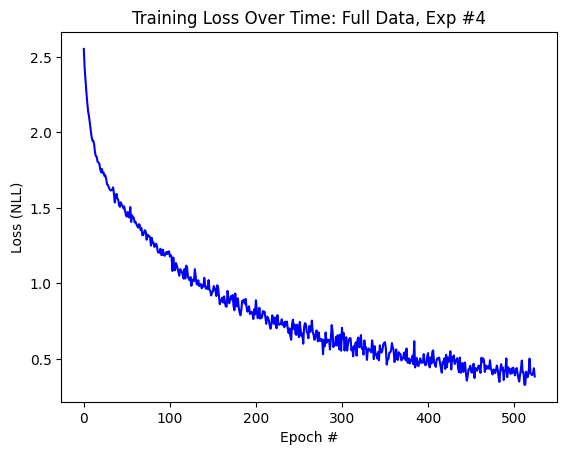

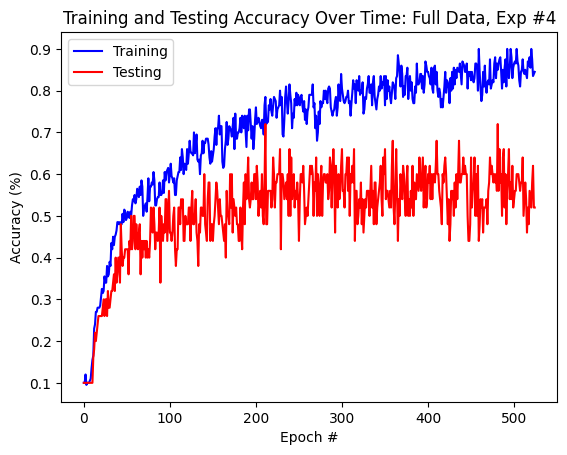

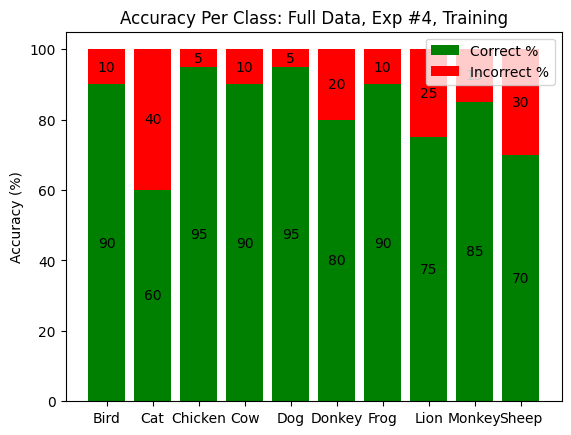

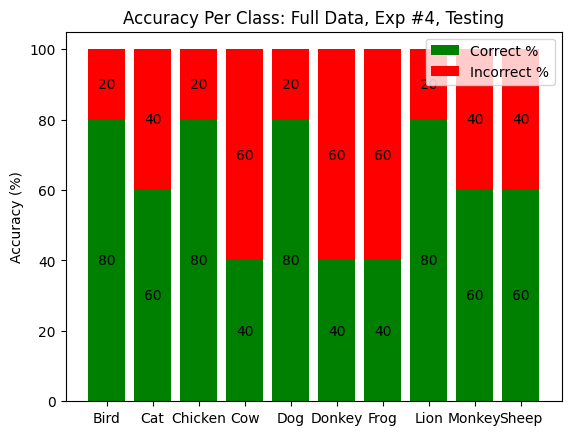

Start of epoch 0
2.479306697845459
Start of epoch 1
2.3840885162353516
Start of epoch 2
2.288442611694336
Start of epoch 3
2.240053176879883
Start of epoch 4
2.1589713096618652
Start of epoch 5
2.1433260440826416
Start of epoch 6
2.0865836143493652
Start of epoch 7
2.053677558898926
Start of epoch 8
2.003896474838257
Start of epoch 9
1.9738945960998535
Start of epoch 10
1.9472846984863281
Start of epoch 11
1.9062668085098267
Start of epoch 12
1.8693275451660156
Start of epoch 13
1.8569793701171875
Start of epoch 14
1.8386508226394653
Start of epoch 15
1.8213461637496948
Start of epoch 16
1.8253549337387085
Start of epoch 17
1.7983649969100952
Start of epoch 18
1.7710943222045898
Start of epoch 19
1.7199217081069946
Start of epoch 20
1.7120226621627808
Start of epoch 21
1.700517177581787
Start of epoch 22
1.7087860107421875
Start of epoch 23
1.7073450088500977
Start of epoch 24
1.6731054782867432
Start of epoch 25
1.6669342517852783
Start of epoch 26
1.637485384941101
Start of epoch 27


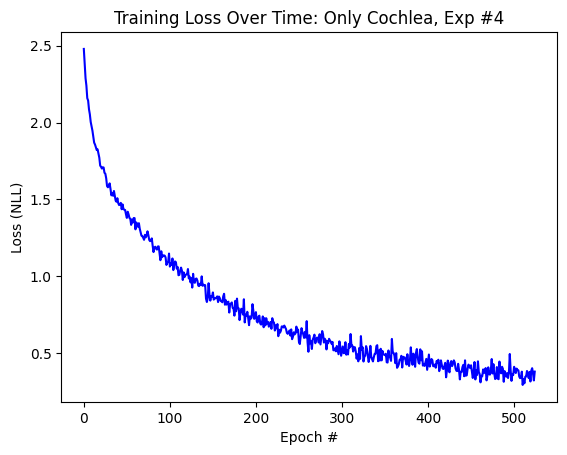

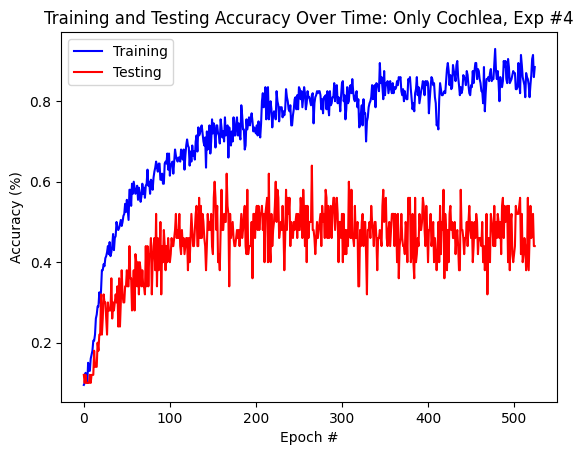

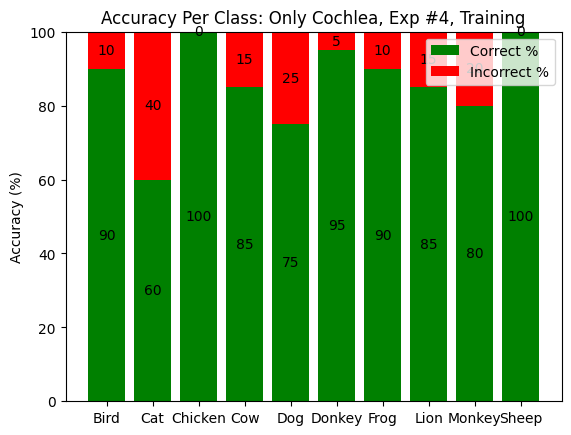

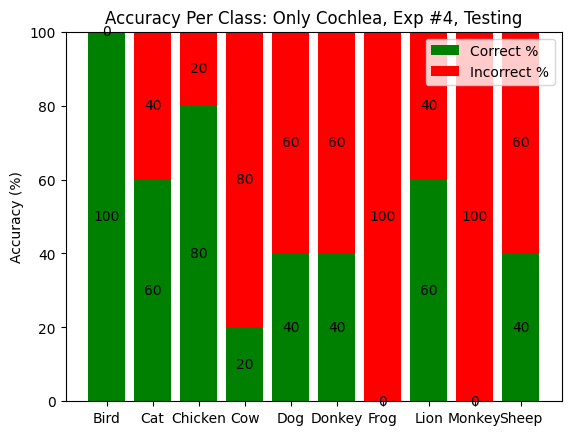

Start of epoch 0
2.7283525466918945
Start of epoch 1
2.5625228881835938
Start of epoch 2
2.4346935749053955
Start of epoch 3
2.348817825317383
Start of epoch 4
2.2836217880249023
Start of epoch 5
2.24322772026062
Start of epoch 6
2.1879870891571045
Start of epoch 7
2.172165632247925
Start of epoch 8
2.1342222690582275
Start of epoch 9
2.1367828845977783
Start of epoch 10
2.0800583362579346
Start of epoch 11
2.080538034439087
Start of epoch 12
2.050847053527832
Start of epoch 13
2.0005381107330322
Start of epoch 14
2.0135560035705566
Start of epoch 15
1.9982409477233887
Start of epoch 16
1.9971896409988403
Start of epoch 17
1.9378180503845215
Start of epoch 18
1.8991509675979614
Start of epoch 19
1.8953697681427002
Start of epoch 20
1.8775581121444702
Start of epoch 21
1.8507767915725708
Start of epoch 22
1.8449841737747192
Start of epoch 23
1.8209606409072876
Start of epoch 24
1.781498670578003
Start of epoch 25
1.7790708541870117
Start of epoch 26
1.7885929346084595
Start of epoch 27


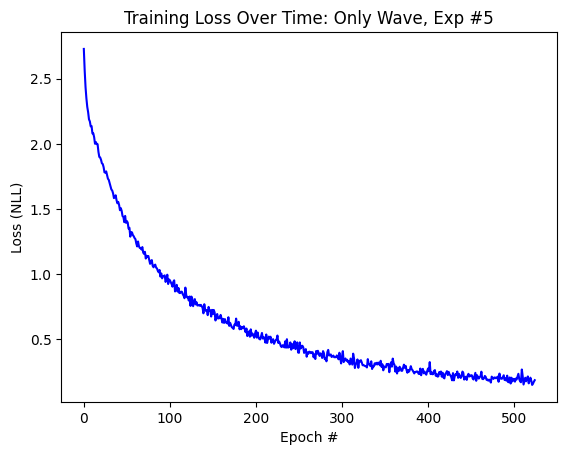

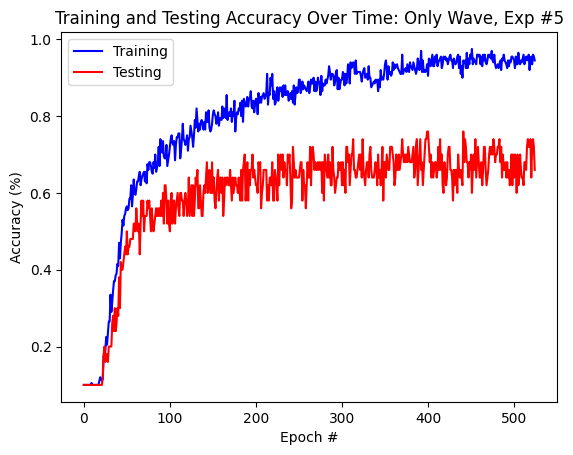

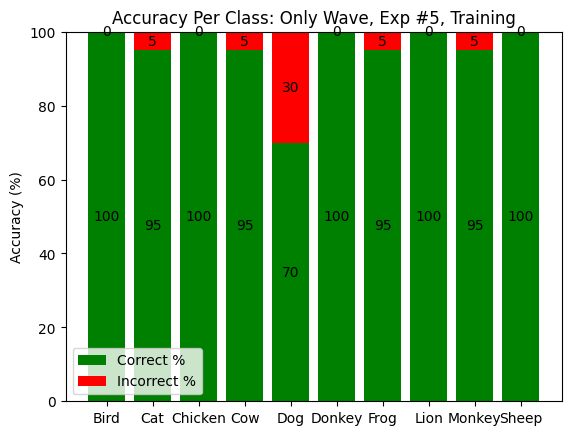

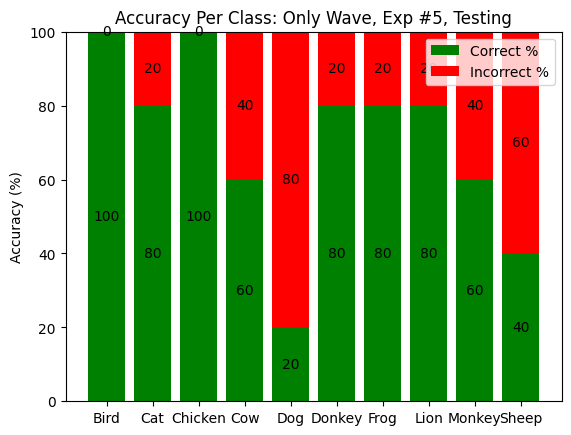

Start of epoch 0
2.5290937423706055
Start of epoch 1
2.425875663757324
Start of epoch 2
2.3476064205169678
Start of epoch 3
2.2324559688568115
Start of epoch 4
2.1828529834747314
Start of epoch 5
2.1305675506591797
Start of epoch 6
2.087960720062256
Start of epoch 7
2.043907880783081
Start of epoch 8
2.0088436603546143
Start of epoch 9
1.9179514646530151
Start of epoch 10
1.9232652187347412
Start of epoch 11
1.9031771421432495
Start of epoch 12
1.872694730758667
Start of epoch 13
1.857718825340271
Start of epoch 14
1.8278288841247559
Start of epoch 15
1.8012361526489258
Start of epoch 16
1.8131461143493652
Start of epoch 17
1.7469418048858643
Start of epoch 18
1.7815735340118408
Start of epoch 19
1.7500932216644287
Start of epoch 20
1.714290976524353
Start of epoch 21
1.7016358375549316
Start of epoch 22
1.7100841999053955
Start of epoch 23
1.707535982131958
Start of epoch 24
1.6909457445144653
Start of epoch 25
1.6743919849395752
Start of epoch 26
1.6546531915664673
Start of epoch 27


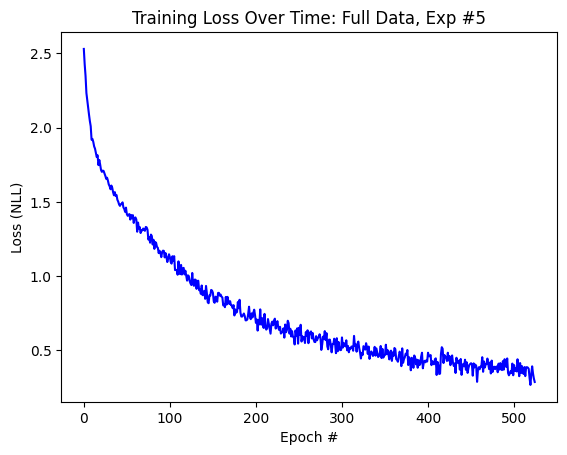

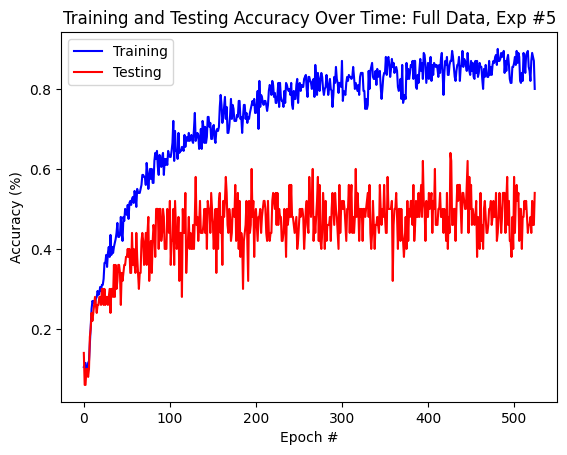

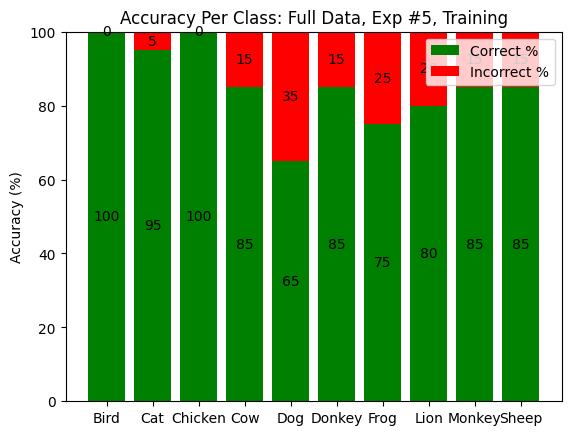

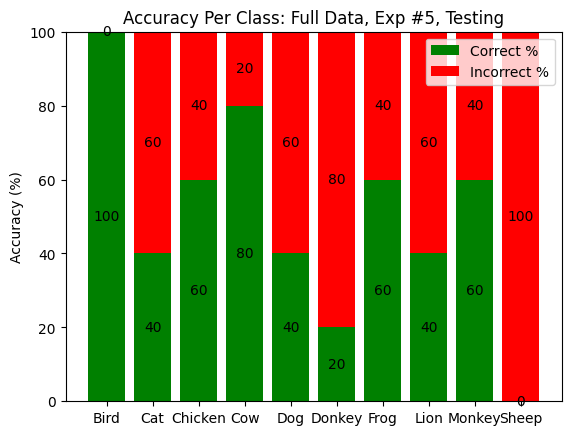

Start of epoch 0
2.5753014087677
Start of epoch 1
2.47231388092041
Start of epoch 2
2.4058997631073
Start of epoch 3
2.3127660751342773
Start of epoch 4
2.253744125366211
Start of epoch 5
2.2050559520721436
Start of epoch 6
2.161668539047241
Start of epoch 7
2.103818893432617
Start of epoch 8
2.06923246383667
Start of epoch 9
1.9861080646514893
Start of epoch 10
1.9794882535934448
Start of epoch 11
1.9556939601898193
Start of epoch 12
1.9268062114715576
Start of epoch 13
1.8743647336959839
Start of epoch 14
1.8743946552276611
Start of epoch 15
1.8826344013214111
Start of epoch 16
1.845409870147705
Start of epoch 17
1.8143932819366455
Start of epoch 18
1.8021492958068848
Start of epoch 19
1.7791939973831177
Start of epoch 20
1.7844161987304688
Start of epoch 21
1.7371128797531128
Start of epoch 22
1.7252929210662842
Start of epoch 23
1.725205421447754
Start of epoch 24
1.6812827587127686
Start of epoch 25
1.6912308931350708
Start of epoch 26
1.677688717842102
Start of epoch 27
1.6814097

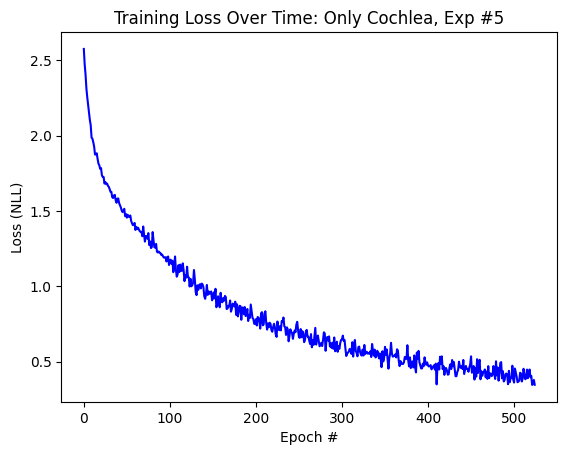

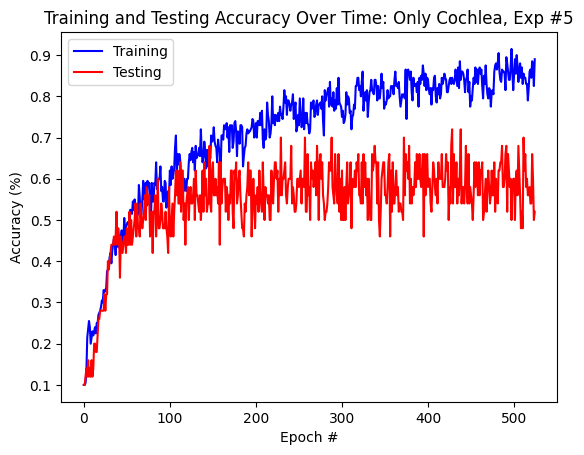

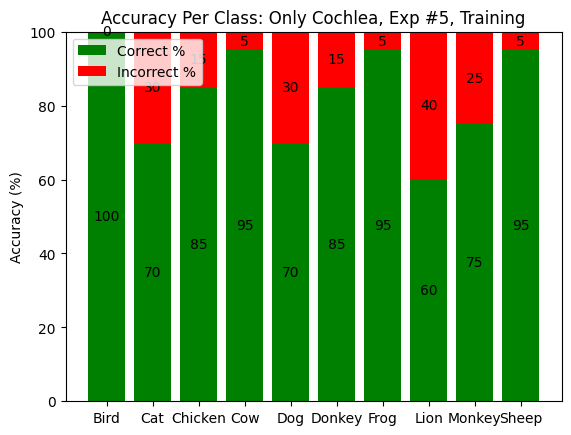

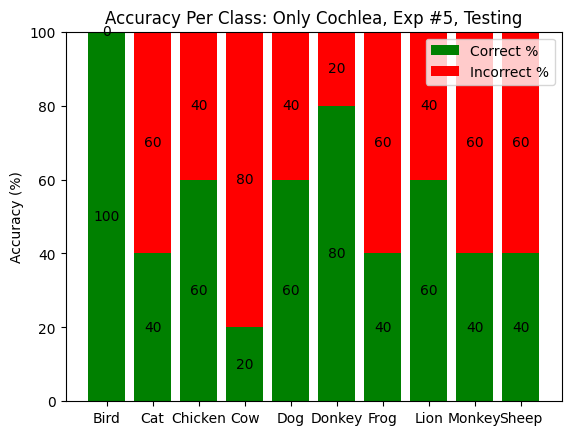

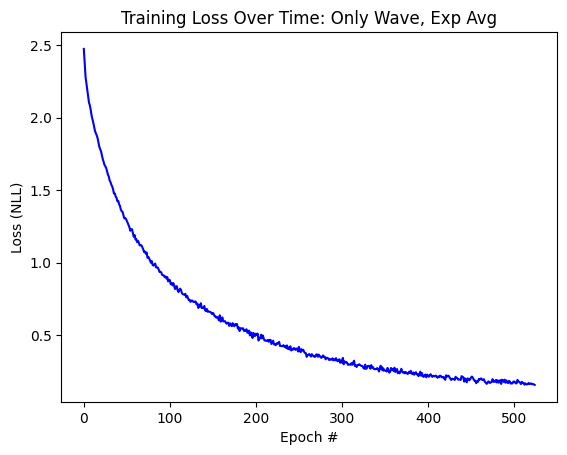

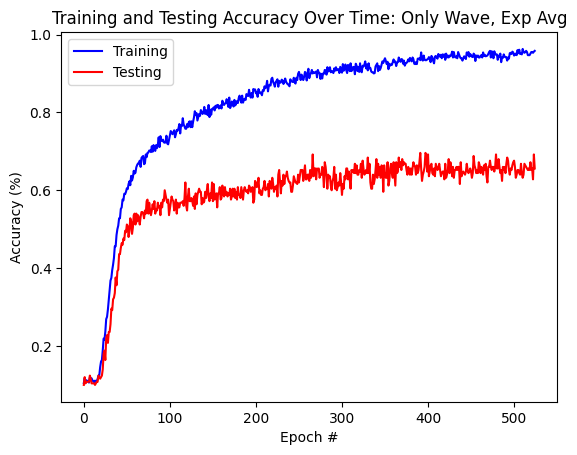

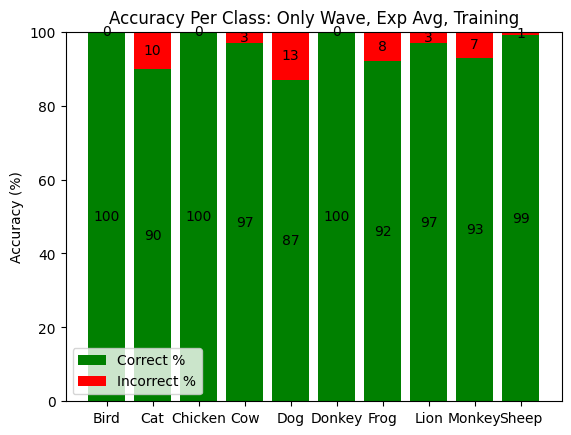

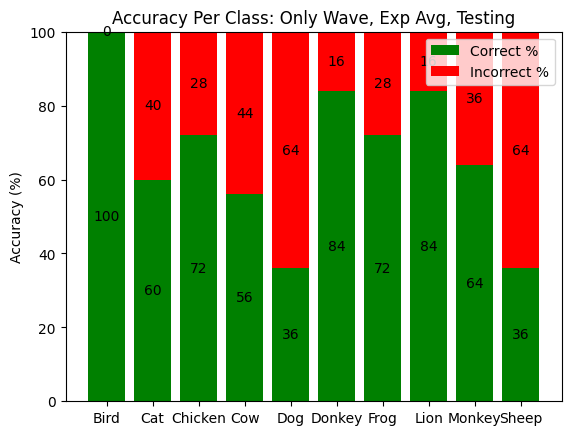

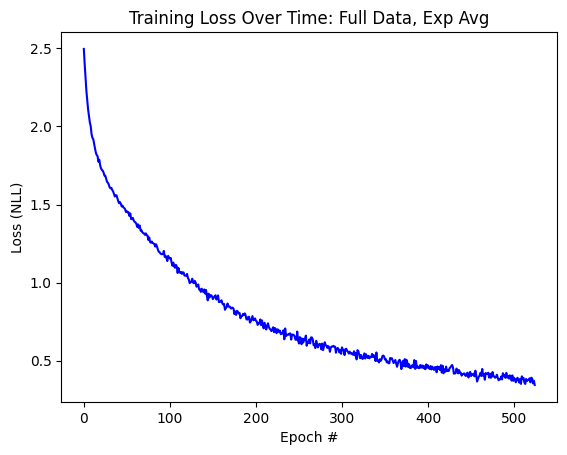

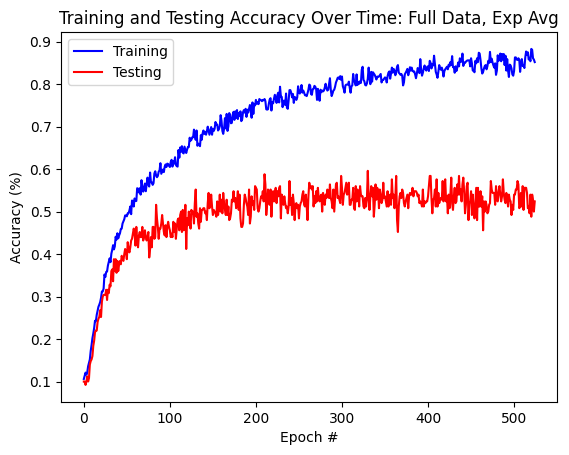

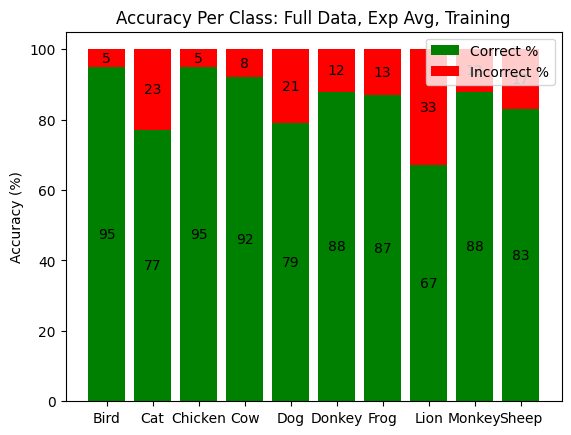

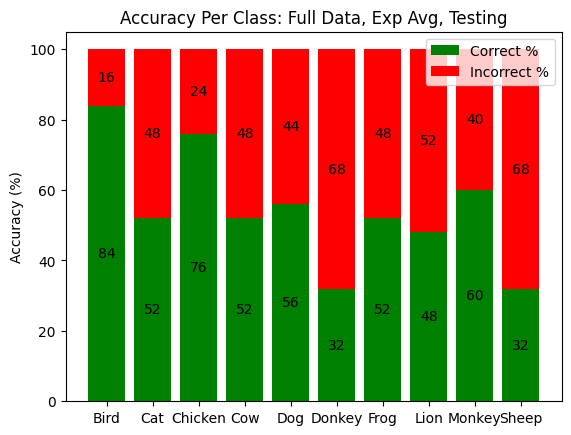

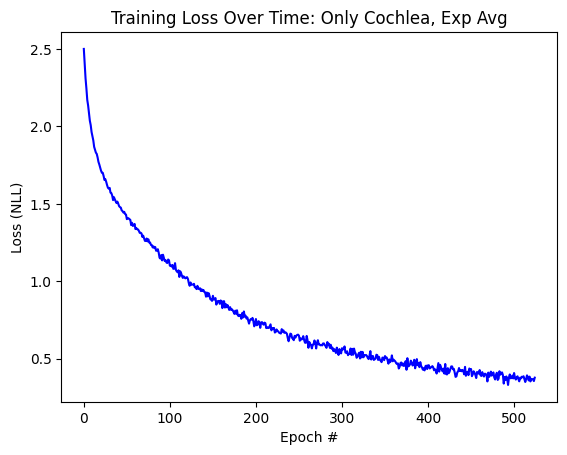

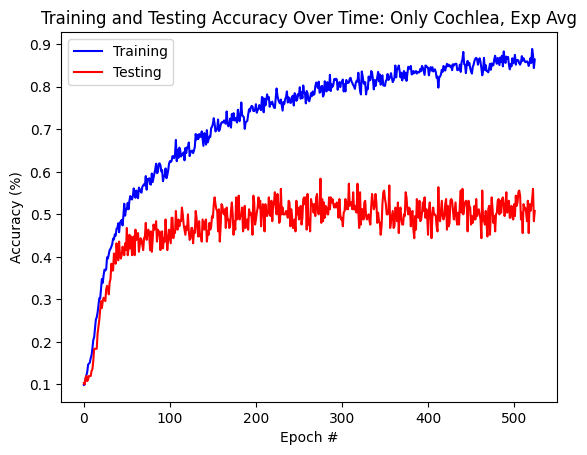

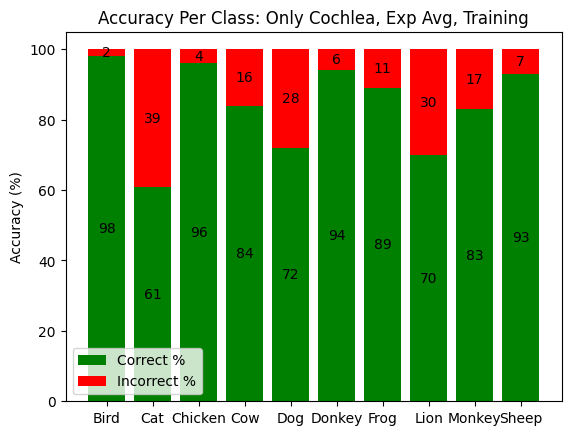

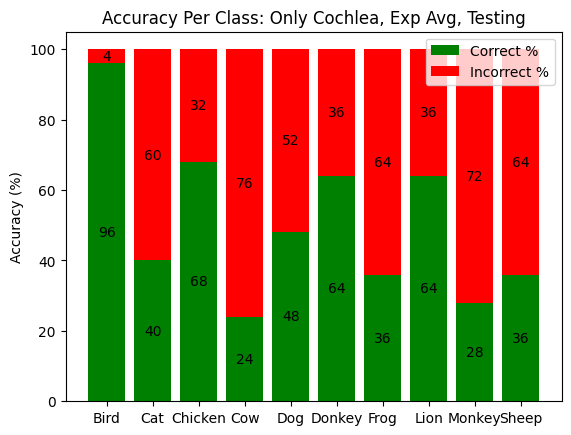

In [113]:
experiment_iterations = 5

epochs = EPOCHS

models = [(1, wave_dataset, 'wave', 'Only Wave'),
        (11, full_dataset, 'full', 'Full Data'),
        (10, freq_dataset, 'freq', 'Only Cochlea')]

total_losses = np.zeros((len(models), experiment_iterations, epochs))
total_train_accs = np.zeros((len(models), experiment_iterations, epochs))
total_test_accs = np.zeros((len(models), experiment_iterations, epochs))
total_class_train = np.zeros((len(models), experiment_iterations, len(labels)))
total_class_test = np.zeros((len(models), experiment_iterations, len(labels)))

for iter in range(experiment_iterations):
    
    for num, (inputs, dataset, type, title) in enumerate(models):
        loss_fn = nn.NLLLoss()
        model = M5(n_input=inputs, n_output=len(labels)).to(device)
        train_loader, test_loader = get_train_test_loaders(dataset)

        title_addition = ': ' + title + ', Exp #' + str(iter + 1)

        # plot_features(train_loader, type, title_addition=title_addition)

        optimizer = torch.optim.Adam(model.parameters())
        train_losses, train_accs, test_accs = train(
            model, loss_fn, optimizer, train_loader, epochs, rnn=False, get_accs=True, test_loader=test_loader
        )
        plot_loss_over_time(train_losses, title_addition=title_addition)
        total_losses[num][iter] = np.array(train_losses)

        plot_train_test_accs(train_accs, test_accs, title_addition=title_addition)
        total_train_accs[num][iter] = np.array(train_accs)
        total_test_accs[num][iter] = np.array(test_accs)

        train_class_accs = eval_per_class(model, train_loader, rnn=False)
        test_class_accs = eval_per_class(model, test_loader, rnn=False)

        total_class_train[num][iter] = np.array(train_class_accs)
        total_class_test[num][iter] = np.array(test_class_accs)

        plot_class_accuracies(train_class_accs, labels, title_addition=title_addition + ', Training')
        plot_class_accuracies(test_class_accs, labels, title_addition=title_addition + ', Testing')

avg_losses = np.mean(total_losses, 1)
avg_train_accs = np.mean(total_train_accs, 1)
avg_test_accs = np.mean(total_test_accs, 1)
avg_class_train = np.mean(total_class_train, 1)
avg_class_test = np.mean(total_class_test, 1)

std_losses = np.std(total_losses[:,:,-1], 1)
std_train_accs = np.std(total_train_accs[:,:,-1], 1)
std_test_accs = np.std(total_test_accs[:,:,-1], 1)

for num, (inputs, dataset, type, title) in enumerate(models):
    title_addition = ': ' + title + ', Exp Avg'
    plot_loss_over_time(avg_losses[num], title_addition=title_addition)
    plot_train_test_accs(avg_train_accs[num], avg_test_accs[num], title_addition=title_addition)
    plot_class_accuracies(avg_class_train[num], labels, title_addition=title_addition + ', Training')
    plot_class_accuracies(avg_class_test[num], labels, title_addition=title_addition + ', Testing')


In [114]:
print(avg_losses.shape, std_losses.shape)
for i in range(3):
    print(['wave','full','freq'][i])
    print('  loss mean', avg_losses[i][-1], 'std=', std_losses[i])
    print('  train acc mean', avg_train_accs[i][-1], 'std=', std_train_accs[i])
    print('  test acc mean', avg_test_accs[i][-1], 'std=', std_test_accs[i])

(3, 525) (3,)
wave
  loss mean 0.1556631878018379 std= 0.029060433391298542
  train acc mean 0.958 std= 0.008717797887081356
  test acc mean 0.656 std= 0.05851495535331118
full
  loss mean 0.3447419285774231 std= 0.040263904220304035
  train acc mean 0.852 std= 0.028390139133156765
  test acc mean 0.524 std= 0.023323807579381222
freq
  loss mean 0.37759132981300353 std= 0.023408823206707275
  train acc mean 0.8639999999999999 std= 0.040792156108742275
  test acc mean 0.508 std= 0.06144916598294887
